# References

Dataset: https://www.kaggle.com/soumikrakshit/anime-faces

Generative adversarial nets: https://arxiv.org/pdf/1406.2661.pdf

DCGAN: https://arxiv.org/pdf/1511.06434.pdf

Ganhacks: https://github.com/soumith/ganhacks

Improved Techniques for Training GANs: https://arxiv.org/pdf/1606.03498.pdf

Torch DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html - Huge amount of code is taken from here!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil 
shutil.unpack_archive("/content/drive/MyDrive/data.zip", "/content/dataset")

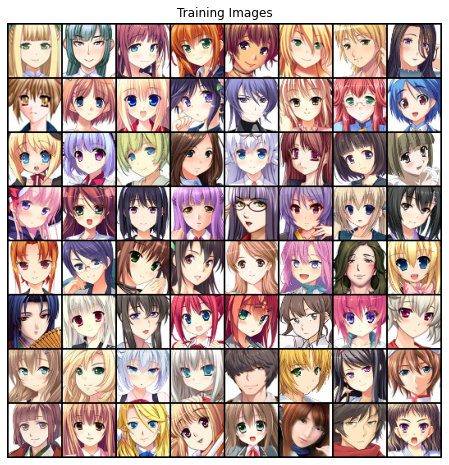

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt




dataroot = '/content/dataset'
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  
                           ]))


batch_size = 128
image_size = 64
ndf = ngf = 64
nc = 3
nz = 100

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0) 

# Generator Architecture
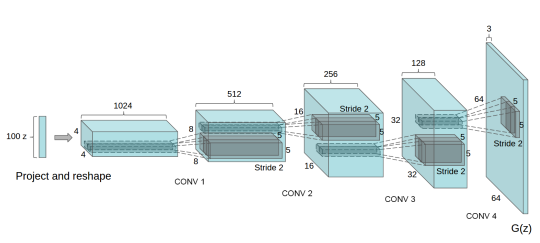

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),

            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTrans

# Discriminator Architecture

Identical to generator but reflected


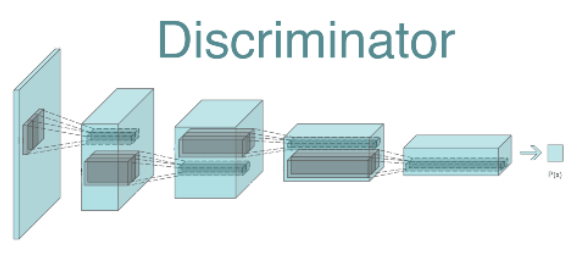

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

# Define Optimizers

In [ ]:
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Load Models

In [ ]:
netD = Discriminator().to(device)  
checkpoint = torch.load('/content/drive/MyDrive/netD_250_epochs.pt', map_location=device)
netD.load_state_dict(checkpoint['model_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizer_state_dict'])
netD.eval()

netG = Generator().to(device)
checkpoint = torch.load('/content/drive/MyDrive/netG_250_epochs.pt', map_location=device)
netG.load_state_dict(checkpoint['model_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizer_state_dict'])
netG.eval()

print('models have been loaded.')

FileNotFoundError: ignored

# Saving Function

In [ ]:
img_list=[]
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

def save_models(epoch, netG, optimizerG, netD, optimizerD):
    torch.save({
            'epoch': epoch,
            'model_state_dict': netG.state_dict(),
            'optimizer_state_dict': optimizerG.state_dict()
            }, '/content/drive/MyDrive/netG_%d_epochs.pt'%epoch)

    torch.save({
            'epoch': epoch,
            'model_state_dict': netD.state_dict(),
            'optimizer_state_dict': optimizerD.state_dict()
            }, '/content/drive/MyDrive/netD_%d_epochs.pt'%epoch)
    
    # Plot the fake images from the last epoch
    m=plt.figure(figsize=(30,30))
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    m = plt.gcf()    
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.draw()
    m.savefig('/content/drive/MyDrive/base_DCGAN_%d_epochs.png'%epoch, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format=None,
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

# Losses

For D and G:

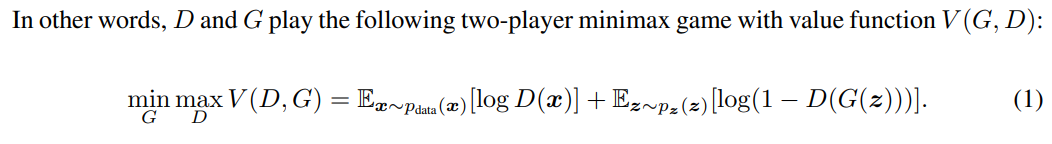

Actual Loss for G: 

log D(G(z))

instead of log(1 − D(G(z))) because of better gradients at first stages.

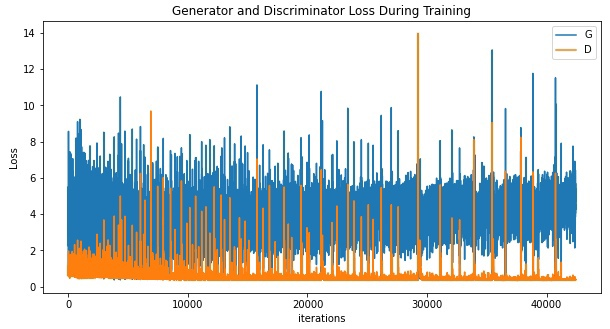

# Main Training Loop

[0/10][0/169]	Loss_D: 1.4701	Loss_G: 0.6100
[0/10][50/169]	Loss_D: 2.9834	Loss_G: 0.3275
[0/10][100/169]	Loss_D: 2.9723	Loss_G: 0.3265
[0/10][150/169]	Loss_D: 2.9632	Loss_G: 0.3258


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.


[1/10][0/169]	Loss_D: 2.8293	Loss_G: 0.3267
[1/10][50/169]	Loss_D: 2.9655	Loss_G: 0.3256
[1/10][100/169]	Loss_D: 2.9271	Loss_G: 0.3254
[1/10][150/169]	Loss_D: 2.8897	Loss_G: 0.3254
[2/10][0/169]	Loss_D: 2.9452	Loss_G: 0.3253
[2/10][50/169]	Loss_D: 2.9219	Loss_G: 0.3253
[2/10][100/169]	Loss_D: 2.9235	Loss_G: 0.3252
[2/10][150/169]	Loss_D: 2.9428	Loss_G: 0.3252
[3/10][0/169]	Loss_D: 2.9392	Loss_G: 0.3252
[3/10][50/169]	Loss_D: 2.9556	Loss_G: 0.3252
[3/10][100/169]	Loss_D: 2.9354	Loss_G: 0.3252
[3/10][150/169]	Loss_D: 2.9323	Loss_G: 0.3252
[4/10][0/169]	Loss_D: 2.9190	Loss_G: 0.3252
[4/10][50/169]	Loss_D: 2.9086	Loss_G: 0.3252
[4/10][100/169]	Loss_D: 2.9444	Loss_G: 0.3251
[4/10][150/169]	Loss_D: 2.8894	Loss_G: 0.3252
[5/10][0/169]	Loss_D: 2.9189	Loss_G: 0.3252
[5/10][50/169]	Loss_D: 2.9446	Loss_G: 0.3252
[5/10][100/169]	Loss_D: 2.9233	Loss_G: 0.3251
[5/10][150/169]	Loss_D: 2.9144	Loss_G: 0.3251
[6/10][0/169]	Loss_D: 2.8893	Loss_G: 0.3251
[6/10][50/169]	Loss_D: 2.9119	Loss_G: 0.3252


KeyboardInterrupt: ignored

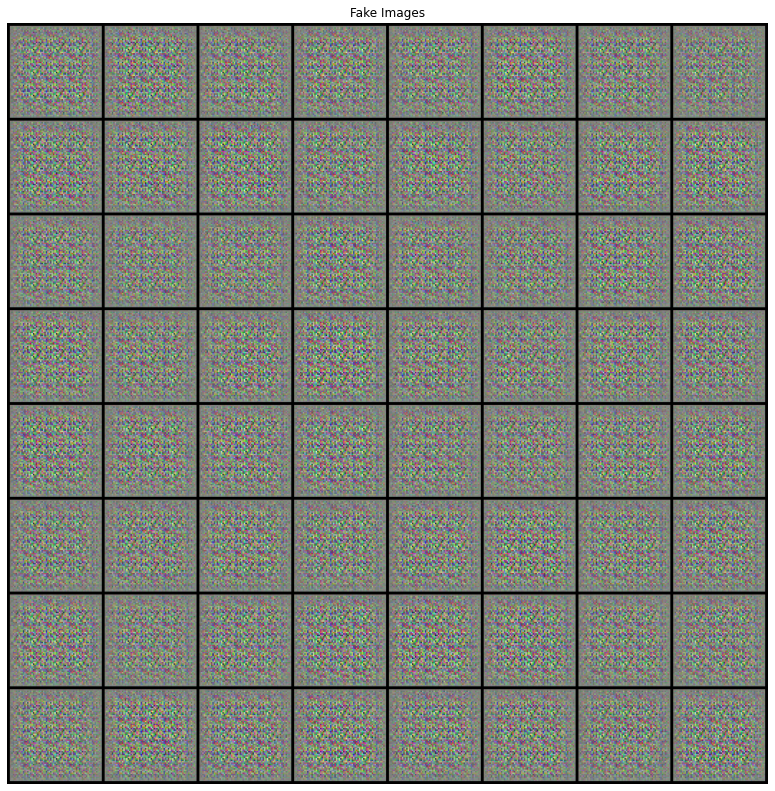

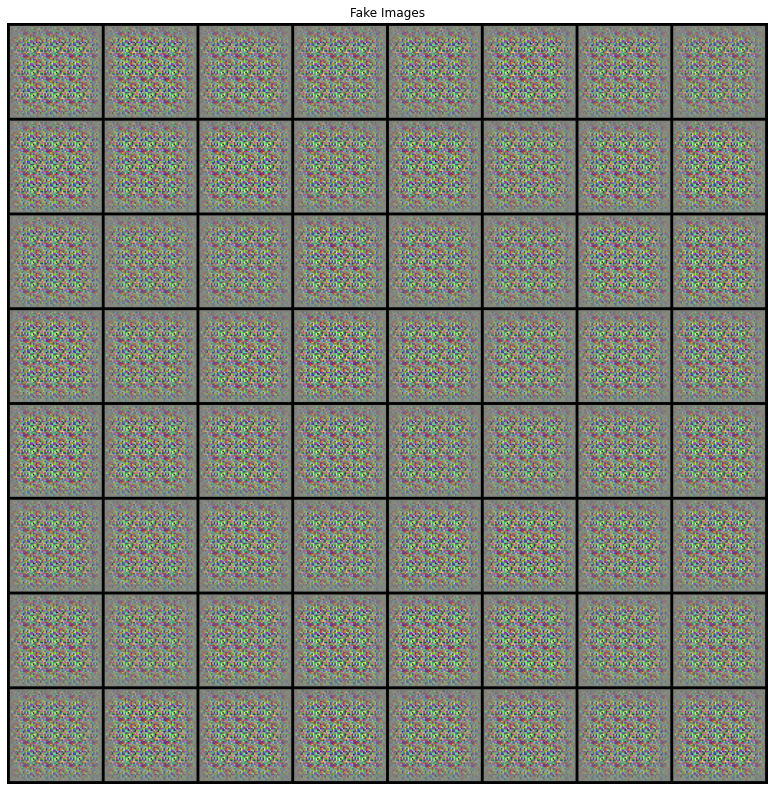

In [ ]:
num_epochs = 10
criterion = nn.BCELoss()
real_label = 0.9
fake_label = 0

G_losses = []
D_losses = []
iters = 0


for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update D network:
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(dataloader),errD.item(), errG.item()))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

    if (epoch%5==0 or epoch==num_epochs-1):
        save_models(epoch, netG, optimizerG, netD, optimizerD) 


plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()        

# Generator's Work Visualization


In [ ]:
fixed_noise = torch.randn(1, nz, 1, 1, device='cpu')
out_im = netG(fixed_noise).detach().cpu()
im = out_im.squeeze()
im = np.transpose(im,(1,2,0))
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


for i in range(len(netG.main)):
    if isinstance(netG.main[i], nn.ConvTranspose2d):
        netG.main[i].register_forward_hook(get_activation(netG.main[i]))
        act = netG.main(fixed_noise)
        act = activation[netG.main[i]].squeeze()
        fig = plt.figure(figsize=(3, 3))
        plt.imshow(act[0])
        plt.title('ConvTransposition2D layer[%d] activation 0'%i)
        plt.axis('off')

fig = plt.figure(figsize=(3, 3))
plt.title('Generated Image')
plt.axis('off')
plt.imshow(im)  

NameError: ignored